In [ ]:
import time
import copy
import random
import functools
import numpy as np

The Agent Class:

In [ ]:
class Agent:

  def __init__(self, start: tuple, goal: tuple, real_stage, view_range=1):
      self.x = start[0]
      self.y = start[1]
      self.goal = goal
      self.view_range = view_range
      self.explored_stage = np.full_like(real_stage, -1)
      self.explored_stage[self.x, self.y] = 0
      self.agent_view(real_stage)
      self.start_time = time.time()

  def agent_view(self, real_stage):
    # refreshes the explored map of the agent (sees up, down, left, right).
    for i in range(self.view_range):
      if self.x > i:  # checks up
        tmp_x = self.x - i - 1
        self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
        if self.y > i:  # up-left
          self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
        if self.y < len(real_stage[0]) - i - 1: # up-right
          self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]

      if self.x < len(real_stage) - i - 1:  # checks down:
        tmp_x = self.x + i + 1
        self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
        if self.y > i:  # down-left
          self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
        if self.y < len(real_stage[0]) - i - 1: # down-right
          self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]

      if self.y > i:  # left
        self.explored_stage[(self.x, self.y - i - 1)] = real_stage[(self.x, self.y - i - 1)]
      if self.y < len(real_stage[0]) - i - 1: # right
        self.explored_stage[(self.x, self.y + i + 1)] = real_stage[(self.x, self.y + i + 1)]

    self.explored_stage[self.explored_stage == 2] = 0

  def check_goal(self):
    if (self.x, self.y) == self.goal:
      return True
    return False

A* Algorithm:

In [ ]:
class Node:
    def __init__(self, x, y, g_cost, h_cost):
        self.x = x
        self.y = y
        self.g_cost = g_cost
        self.h_cost = h_cost
        self.parent = None

    def f_cost(self):
        return self.g_cost + self.h_cost

def is_valid(x, y, grid):
    # Checks if the x and y are within grid + if no obs in (x, y).
    rows, cols = grid.shape
    return 0 <= x < rows and 0 <= y < cols and grid[x, y] <= 0

def a_star(grid, start, end):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
    rows, cols = grid.shape

    open_set = []
    closed_set = set()

    start_node = Node(start[0], start[1], 0, 0)
    open_set.append(start_node)

    while open_set:
        # Finds the lowest f_cost node -> adds it to the closed_set.
        current_node = min(open_set, key=lambda node: node.f_cost())
        open_set.remove(current_node)
        closed_set.add((current_node.x, current_node.y))

        # If current node is the target node -> returns the path.
        if (current_node.x, current_node.y) == end:
            path = []
            while current_node:
                path.insert(0, (current_node.x, current_node.y))
                current_node = current_node.parent
            return path


        for dx, dy in directions:

            # Gets the new pos:
            new_x, new_y = current_node.x + dx, current_node.y + dy
            if is_valid(new_x, new_y, grid) and (new_x, new_y) not in closed_set:
                g_cost = current_node.g_cost + 1  # g_cost (distance) from current node is 1.
                h_cost = abs(new_x - end[0]) + abs(new_y - end[1])
                new_node = Node(new_x, new_y, g_cost, h_cost)
                new_node.parent = current_node

                if new_node not in open_set:
                    open_set.append(new_node)

    return None  # No path found

Create a stage with obstacles (1) and free path (0).

In [ ]:
def generate_stage(rows: int, cols: int, obs_prob = 0.2):

  # generate obstacles with obs_prob probability
  num_obstacles = int(rows * cols * obs_prob)

  stage = np.full((rows, cols), 0)

  # Set 1s at random positions for the specified percentage
  indices = np.random.choice(rows * cols, num_obstacles, replace=False)
  stage.flat[indices] = 1

  return stage

 Creates the "explored" stage, which at the start everything is not explored (-1) and put the agents there (2).

In [ ]:
def generate_agents(real_stage, num_agents: int = 1):

  agents = []

  if num_agents <= 0:
    num_agents = 1

  zero_coordinates = list(zip(*np.where(real_stage == 0)))

  # Create the "explored" stage
  for _ in range(num_agents):
    if zero_coordinates:
      start = random.choice(zero_coordinates)
      zero_coordinates.remove(start)
      goal = random.choice(zero_coordinates)
      agents.append(Agent((start[0], start[1]), (goal[0], goal[1]), real_stage))
    else:
      break

  return agents

Function to concat all agents explored stages (returns the total explored stage):

In [ ]:
def update_total_explored(agents):
  if len(agents) == 0:
    return

  total_explored = np.full(agents[0].explored_stage.shape, -1)

  for a in agents:
    total_explored[total_explored == -1] = a.explored_stage[total_explored == -1]
    total_explored[total_explored == 2] = 0

  for a in agents:
    if not a.check_goal():  # if agent has reached goal -> collidable (as if it is removed from the stage).
      total_explored[a.x, a.y] = 2

  # Total explored contains the concats of all agents stages:
  for a in agents:
    a.explored_stage = copy.deepcopy(total_explored)

  return total_explored

Calculates the explored percentage of the concat stage:

In [ ]:
def calculate_expl_percentage(total_explored):
  num_minus_1 = np.sum(total_explored == -1)
  explored_percentage = 1 - (num_minus_1 / (total_explored.shape[0] * total_explored.shape[1]))
  return explored_percentage

Function for testing astar:

In [ ]:
def move_astar(start_grid, start_agents, max_episodes=100, debug=True):

  grid = copy.deepcopy(start_grid)

  agents = copy.deepcopy(start_agents)

  for agent in agents:
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
  total_explored = update_total_explored(agents)
  prev_tot_expl = copy.deepcopy(total_explored)
  episode = 0
  total_agents = len(agents)

  avg_eps_time = []
  avg_agent_time = []

  while any((agent.x, agent.y) != agent.goal for agent in agents) and episode < max_episodes:
      eps_start_time = time.time()
      episode += 1
      # print(episode)
      if debug:
          print(total_explored)

      for agent in agents:
          if (agent.x, agent.y) == agent.goal:
              total_explored = update_total_explored(agents)
              agents.remove(agent)
              continue  # Agent has reached its goal

          path = a_star(agent.explored_stage, (agent.x, agent.y), agent.goal)
          # print(total_explored)
          if path:
              grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
              agent.x, agent.y = path[1]  # Update agent position
              grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
              if agent.check_goal():
                avg_agent_time.append(time.time() - agent.start_time)
              # print(grid)
          agent.agent_view(start_grid)
          total_explored = update_total_explored(agents)
      avg_eps_time.append(time.time() - eps_start_time)
      if np.array_equal(prev_tot_expl, total_explored): # stops if no agents have moved.
          break
      prev_tot_expl = copy.deepcopy(total_explored)

  if debug:
      print(total_explored)
  return calculate_expl_percentage(total_explored), len(avg_agent_time) / total_agents, total_explored, np.mean(avg_eps_time), np.mean(avg_agent_time)

Manual Examples:

In [ ]:
grid = np.array([[0, 0, 1, 0, 0],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0]])

print("LESS OBSTACLES STAGE")
agents = [Agent((0, 0), (4, 4), grid, 2), Agent((0, 4), (4, 0), grid),]
res = move_astar(grid, agents)
print(f"Total Coverage Percentage {res[0]} / Agents Finished: {res[1]} / Average Episode Time: {res[3]} / Average Agent Finish Time : {res[4]}")
print(f"Final Explored Stage\n{res[2]}")

In [ ]:
grid = np.array([[0, 0, 1, 1, 0],
                 [0, 1, 1, 0, 1],
                 [0, 0, 1, 0, 1],
                 [0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0]])

print("MANY OBSTACLES STAGE")
agents = [Agent((0, 0), (4, 4), grid), Agent((0, 1), (4, 4), grid)]
res = move_astar(grid, agents)
print(f"Total Coverage Percentage {res[0]} / Agents Finished: {res[1]} / Average Episode Time: {res[3]} / Average Agent Finish Time : {res[4]}")
print(f"Final Explored Stage\n{res[2]}")

Function for maze creation. [Source](https://medium.com/@msgold/using-python-to-create-and-solve-mazes-672285723c96).

In [ ]:
from queue import Queue

def create_maze(rows, cols, obs_prob=0.8):
    rows = int(rows / 2)
    cols = int(cols / 2)

    maze = np.ones((rows*2+1, cols*2+1))

    x, y = (0, 0)

    stack = [(x, y)]
    while len(stack) > 0:
        x, y = stack[-1]

        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < rows and ny < cols and maze[2*nx+1, 2*ny+1] == 1:
                maze[2*nx+1, 2*ny+1] = 0
                maze[2*x+1+dx, 2*y+1+dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()

    for row in range(rows*2+1):
        for col in range(cols*2+1):
            if random.random() >= obs_prob:
                maze[row][col] = 0

    return maze

Function to plot the grid/maze:

In [ ]:
import matplotlib.pyplot as plt

def draw_maze(maze, path=None):
    fig, ax = plt.subplots(figsize=(10,10))

    fig.patch.set_edgecolor('white')
    fig.patch.set_linewidth(0)

    ax.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')

    if path is not None:
        x_coords = [x[1] for x in path]
        y_coords = [y[0] for y in path]
        ax.plot(x_coords, y_coords, color='red', linewidth=2)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

Function to test astar with many experiments (print averages).

In [ ]:
def test_astar(num_agents, num_test, start_grid, *gen_stage_func):
  """
  Function to test astar with many experiments (returns averages).
  If you want to give the initial grid, initialize the variable start_grid with your grid
  (and put the gen_stage_func parameter = None).
  If you want to create a different stage for each experiment, put start_grid = None
  and initialize the next parameter (gen_stage_func) like so:
  functools.partial(func_for_grid_gen, rows, cols, obs_prob)
  where func_for_grid_gen is a function for grid generation, rows and cols are the number
  of rows and columns of the grid and obs_prob the probablity of obstacles.
  """
  avg = []
  avg_finish = []
  avg_exp_time = []
  avg_agent_time = []
  avg_eps_time= []

  for _ in range(num_test):
    start_time = time.time()
    if start_grid is None:
      grid = gen_stage_func[0]()
      # print(grid)
    else:
      grid = copy.deepcopy(start_grid)
    agents = generate_agents(real_stage = grid, num_agents = num_agents)
    res = move_astar(start_grid=grid, start_agents=agents, debug=False)
    avg.append(res[0])
    avg_finish.append(res[1])
    avg_exp_time.append(time.time() - start_time)
    avg_eps_time.append(res[3])
    avg_agent_time.append(res[4])
  avg_agent_time = [x if not np.isnan(x) else max(avg_agent_time) for x in avg_agent_time]  # replaces nans with max value.
  # print(avg, avg_finish, avg_exp_time, avg_eps_time, avg_agent_time)
  print(f"Average Coverage Percentage: {np.mean(avg)} / Average Finished: {np.mean(avg_finish)} / Average Experiment Time: {np.mean(avg_exp_time)}s / Average Episode Time: {np.mean(avg_eps_time)} / Average Agent Finish Time : {np.mean(avg_agent_time)}")


Testing with dynamically generated stages:

In [ ]:
num_agents = 15
num_test = 10

test_astar(num_agents, num_test, None, functools.partial(generate_stage, rows=10, cols=10, obs_prob=0.5))

Average Coverage Percentage: 0.807 / Average Finished: 0.07999999999999999 / Average Experiment Time: 0.051081371307373044s / Average Episode Time: 0.011247992515563965 / Average Agent Finish Time : 0.045090246200561526


Generate test maze:

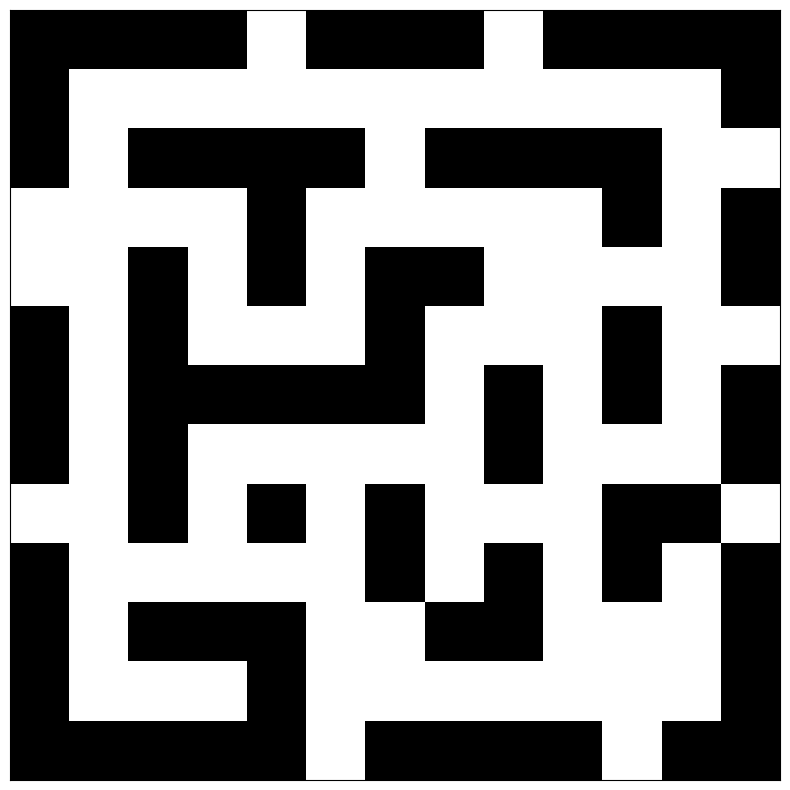

In [ ]:
grid_rows, grid_columns = 13, 13
obs_prob = 0.85
test_maze = create_maze(grid_rows, grid_columns, obs_prob)
draw_maze(test_maze)

Solve the test_maze with 20 agents:

In [ ]:
num_agents = 20 # number of agents.
num_test = 10
test_astar(num_agents, num_test, test_maze, None)

Average Coverage Percentage: 0.9603550295857988 / Average Finished: 0.8799999999999999 / Average Experiment Time: 0.40250816345214846s / Average Episode Time: 0.00623896714555916 / Average Agent Finish Time : 0.2670312137149512


Solve the test_maze with 10 agents:

In [ ]:
num_agents = 10 # number of agents.
num_test = 10
test_astar(num_agents, num_test, test_maze, None)

Average Coverage Percentage: 0.9023668639053255 / Average Finished: 0.9 / Average Experiment Time: 3.9952550411224363s / Average Episode Time: 0.1165440030966145 / Average Agent Finish Time : 3.520903224945068


**OLD VERSION** of the Agent Class:
```
class Agent:

  def __init__(self, x, y, direction, real_stage, explored_stage):
    self.x = x
    self.y = y
    self.direction = direction  # 'up', 'down', 'left', 'right'
    self.real_stage = real_stage  # contains obstacles and paths
    self.explored_stage = explored_stage  # explored stage (contains agents)

  def move_left(self):
    self.direction = "left"
    if self.y > 0:
      if self.real_stage[(self.x, self.y - 1)] or self.explored_stage[(self.x, self.y - 1)]:  # obs or other agent
        print("obs")
        self.refresh_agent_view()
        return
      self.explored_stage[(self.x, self.y)] = 0
      self.y -= 1
      self.explored_stage[(self.x, self.y)] = 2
      self.refresh_agent_view()

  def move_right(self):
    self.direction = 'right'
    if self.y < len(self.explored_stage[0]) - 1:
      if self.real_stage[(self.x, self.y + 1)] or self.explored_stage[(self.x, self.y + 1)]:  # obs or other agent
        print("obs")
        self.refresh_agent_view()
        return
      self.explored_stage[(self.x, self.y)] = 0
      self.y += 1
      self.explored_stage[(self.x, self.y)] = 2
      self.refresh_agent_view()

  def move_up(self):
    self.direction = 'up'
    if self.x > 0:
      if self.real_stage[(self.x - 1, self.y)] or self.explored_stage[(self.x - 1, self.y)]:  # obs or other agent
        print("obs")
        self.refresh_agent_view()
        return
      self.explored_stage[(self.x, self.y)] = 0
      self.x -= 1
      self.explored_stage[(self.x, self.y)] = 2
      self.refresh_agent_view()

  def move_down(self):
    self.direction = 'down'
    if self.x < len(self.explored_stage) - 1:
      if self.real_stage[(self.x + 1, self.y)] or self.explored_stage[(self.x + 1, self.y)]:  # obs or other agent
        print("obs")
        self.refresh_agent_view()
        return
      self.explored_stage[(self.x, self.y)] = 0
      self.x += 1
      self.explored_stage[(self.x, self.y)] = 2
      self.refresh_agent_view()

  def refresh_agent_view(self):
    # Generate agent view =======
    # Ex. If agent looks up -> knows both up, left and right (/w sensors).
    if self.direction == "up":
      if self.x > 0:
        if self.explored_stage[(self.x - 1, self.y)] < 0: # unexplored
          self.explored_stage[(self.x - 1, self.y)] = self.real_stage[(self.x - 1, self.y)]
      if self.y < len(self.real_stage[0]) - 1:
        if self.explored_stage[(self.x, self.y + 1)] < 0:
          self.explored_stage[(self.x, self.y + 1)] = self.real_stage[(self.x, self.y + 1)]
      if self.y > 0:
        if self.explored_stage[(self.x, self.y - 1)] < 0:
          self.explored_stage[(self.x, self.y - 1)] = self.real_stage[(self.x, self.y - 1)]

    elif self.direction == "down":
      if self.x < len(self.real_stage) - 1:
        if self.explored_stage[(self.x + 1, self.y)] < 0:
          self.explored_stage[(self.x + 1, self.y)] = self.real_stage[(self.x - 1, self.y)]
      if self.y < len(self.real_stage[0]) - 1:
        if self.explored_stage[(self.x, self.y + 1)] < 0:
          self.explored_stage[(self.x, self.y + 1)] = self.real_stage[(self.x, self.y + 1)]
      if self.y > 0:
        if self.explored_stage[(self.x, self.y - 1)] < 0:
          self.explored_stage[(self.x, self.y - 1)] = self.real_stage[(self.x, self.y - 1)]

    elif self.direction == "left":
      if self.y > 0:
        if self.explored_stage[(self.x, self.y - 1)] < 0:
          self.explored_stage[(self.x, self.y - 1)] = self.real_stage[(self.x, self.y - 1)]
      if self.x < len(self.real_stage) - 1:
        if self.explored_stage[(self.x + 1, self.y)] < 0:
          self.explored_stage[(self.x + 1, self.y)] = self.real_stage[(self.x + 1, self.y)]
      if self.x > 0:
        if self.explored_stage[(self.x - 1, self.y)] < 0:
          self.explored_stage[(self.x - 1, self.y)] = self.real_stage[(self.x - 1, self.y)]

    elif self.direction == "right":
      if self.y < len(self.real_stage[0]) - 1:
        if self.explored_stage[(self.x, self.y + 1)] < 0:
          self.explored_stage[(self.x, self.y + 1)] = self.real_stage[(self.x, self.y + 1)]
      if self.x < len(self.real_stage) - 1:
        if self.explored_stage[(self.x + 1, self.y)] < 0:
          self.explored_stage[(self.x + 1, self.y)] = self.real_stage[(self.x + 1, self.y)]
      if self.x > 0:
        if self.explored_stage[(self.x - 1, self.y)] < 0:
          self.explored_stage[(self.x - 1, self.y)] = self.real_stage[(self.x - 1, self.y)]

```


Check agent view:

In [ ]:
grid = np.array([[0, 0, 1, 0, 0],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0]])

agents = [Agent((2, 2), (2, 2), grid, 2),]
res = move_astar(grid, agents)


In [ ]:
import numpy as np

grid = np.array([[0, 0, -1, -1, 1],
                 [0, 2, 0, -1, -1],
                 [-1, 0, -1, -1, -1],
                 [-1, -1, -1, -1, -1],
                 [-1, 0, -1, -1, -1]])

coordinates = np.where(grid == 2)
x, y = coordinates[0][0], coordinates[1][0]

# print(grid[:x]) # up
# print(grid[x + 1:]) # down

# print(grid[:, y + 1:])  # right
# print(grid[:, :y])  # left

above_count = np.sum(grid[:x] == -1)
below_count = np.sum(grid[x + 1:] == -1)
right_count = np.sum(grid[:, y + 1:] == -1)
left_count = np.sum(grid[:, :y] == -1)

print(above_count, below_count, right_count, left_count)

In [ ]:
l = [0, 1, 1, 0]
print(l.index(max(l)))